## EDA Overview - Home-Credit Risk

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt


In [2]:
app_train = pd.read_csv('../data/raw/home_credit/application_train.csv')
app_test = pd.read_csv('../data/raw/home_credit/application_test.csv')
bureau = pd.read_csv('../data/raw/home_credit/bureau.csv')
bureau_balance = pd.read_csv('../data/raw/home_credit/bureau_balance.csv')
prev = pd.read_csv('../data/raw/home_credit/previous_application.csv')
pos = pd.read_csv('../data/raw/home_credit/POS_CASH_balance.csv')
ins = pd.read_csv('../data/raw/home_credit/installments_payments.csv')
cc = pd.read_csv('../data/raw/home_credit/credit_card_balance.csv')

## Project snapshot

In [ ]:
def audit(df, name):
    return {
        "dataset": name,
        "rows": len(df),
        "cols": df.shape[1],
        "numeric": df.select_dtypes("number").shape[1],
        "categorical": df.select_dtypes(include=["object","category","bool"]).shape[1],
        "missing_pct_mean": df.isna().mean().mean() * 100,
    }

summary = pd.DataFrame([
    audit(app_train, "application_train"),
    audit(app_test, "application_test"),
    audit(bureau, "bureau"),
    audit(prev, "previous_application"),
    audit(pos, "pos_cash"),
    audit(ins, "installments"),
    audit(cc, "credit_card"),
    audit(bureau_balance, "bureau_balance"),
]).sort_values("rows", ascending=False)
summary


In [ ]:
# Get value counts
target_counts = app_train["TARGET"].value_counts().sort_index()
labels = target_counts.index.map({0: "Paid (0)", 1: "Default (1)"})
colors = ["steelblue", "crimson"]

# Plot
plt.figure(figsize=(6, 4))
bars = plt.bar(labels, target_counts.values, color=colors)

# Add text on bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 500, yval, ha="center", va="bottom")

# Titles and labels
plt.title("Distribution of TARGET variable")
plt.xlabel("TARGET class")
plt.ylabel("Number of applicants")
plt.tight_layout()
plt.show()

# Unpaid loan percentage
unpaid_pct = target_counts.loc[1] / target_counts.sum() * 100
print(f"Percentage of unpaid loans (TARGET=1): {unpaid_pct:.2f}%")

## Coverage and joinability check

In [16]:
aux = {
    "bureau": bureau["SK_ID_CURR"].nunique(),
    "previous": prev["SK_ID_CURR"].nunique(),
    "pos_cash": pos["SK_ID_CURR"].nunique(),
    "installments": ins["SK_ID_CURR"].nunique(),
    "credit_card": cc["SK_ID_CURR"].nunique(),
}
all_customers = app_train["SK_ID_CURR"].nunique() + app_test["SK_ID_CURR"].nunique()
cov = pd.DataFrame([
    {"table": k, "customers": v, "coverage_pct": 100 * v / all_customers}
    for k, v in aux.items()
]).sort_values("coverage_pct", ascending=False)
cov

,table,customers,coverage_pct
3,installments,339587,95.321329
1,previous,338857,95.116419
2,pos_cash,337252,94.665899
0,bureau,305811,85.840479
4,credit_card,103558,29.068504


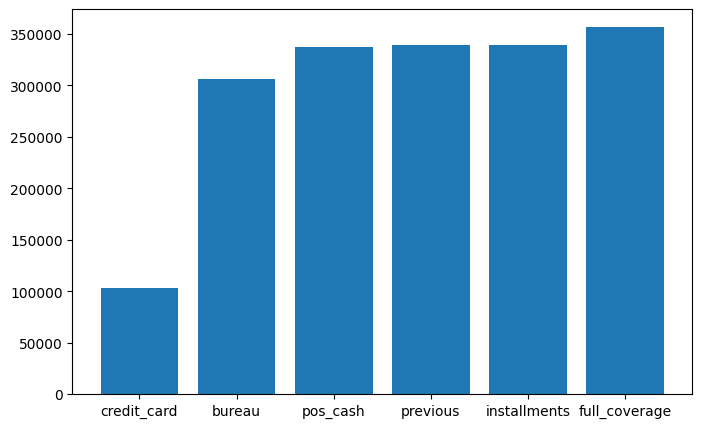

In [46]:
all_customers_entry: dict = {'table':'full_coverage', 'customers':all_customers, 'coverage_pct':100}

plt.figure(figsize=(8,5))

cov.loc[len(cov)] = all_customers_entry
cov = cov.sort_values('coverage_pct', ascending=True)
plt.bar(
    x = cov['table'],
    height = cov['customers'], 
)
plt.show()

## Data quality spotlight

In [33]:
def missing_values_table(df):
    # Total missing values
    mis_val = df.isnull().sum()
    
    # Percentage of missing values
    mis_val_percent = 100 * mis_val / len(df)
    
    # Create a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(columns={0: 'Missing Values', 1: 'Percentage'})
    
    # Sort the table by percentage of missing values
    mis_val_table_ren_columns = mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:, 1] != 0].sort_values(
        'Percentage', ascending=False).round(1)
    
    # Summary of missing values
    print(f"There are {mis_val_table_ren_columns.shape[0]} columns that have missing values. These are the top 15 below:")
    
    return mis_val_table_ren_columns.head(15)

In [34]:
missing_values_table(app_train)

There are 67 columns that have missing values. These are the top 15 below:


,Missing Values,Percentage
COMMONAREA_MEDI,214865,69.9
COMMONAREA_MODE,214865,69.9
COMMONAREA_AVG,214865,69.9
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_AVG,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_MODE,210199,68.4


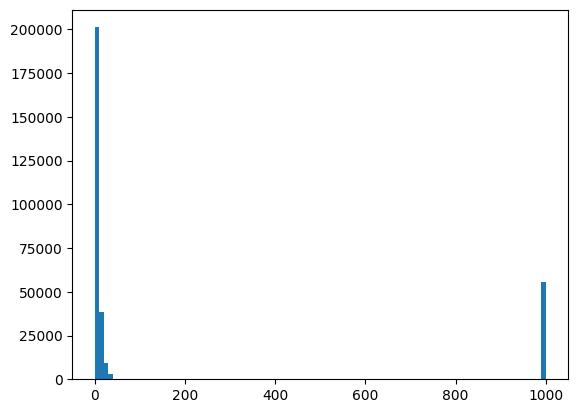

In [45]:
cent_age = 365.25 * 100

age = abs(app_train['DAYS_EMPLOYED'] / 365.25)

plt.hist(
    age,
    bins=100
         )
plt.show()

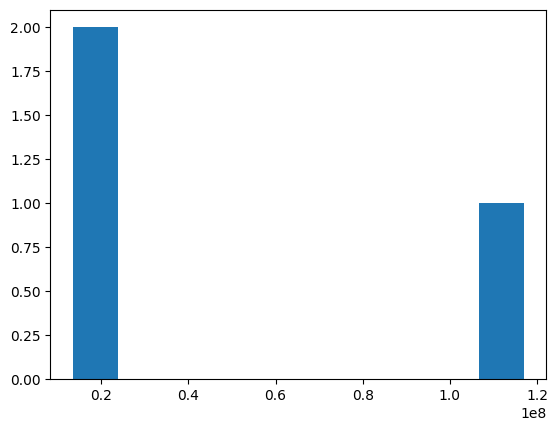

In [58]:
income_over_10_mil = app_train['AMT_INCOME_TOTAL'].loc[app_train['AMT_INCOME_TOTAL'] >= 10_000_000]

plt.hist(
    income_over_10_mil
         )
plt.show()